In [4]:
import nltk
import re
import pandas as pd
import numpy as np
from enum import Enum
from scipy.sparse import hstack

from gensim.models import Word2Vec

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from nltk import pos_tag, ne_chunk, Tree
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from textblob import TextBlob
import spacy

# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [1]:
# for yong jie
# df = pd.read_csv('/content/drive/MyDrive/NUS/Y3S2/CS4248/CS4248 Project/raw_data/fulltrain.csv', header=None, names=['Verdict ', 'Text'])

# for en hao
df = pd.read_csv('./raw_data/fulltrain.csv', header=None, names=['Verdict', 'Text'])
df_test = pd.read_csv('./raw_data/balancedtest.csv', header=None, names=['Verdict', 'Text'])

X_train = df['Text']
y_train = df['Verdict']
X_test = df_test['Text']
y_test = df_test['Verdict']

NameError: name 'pd' is not defined

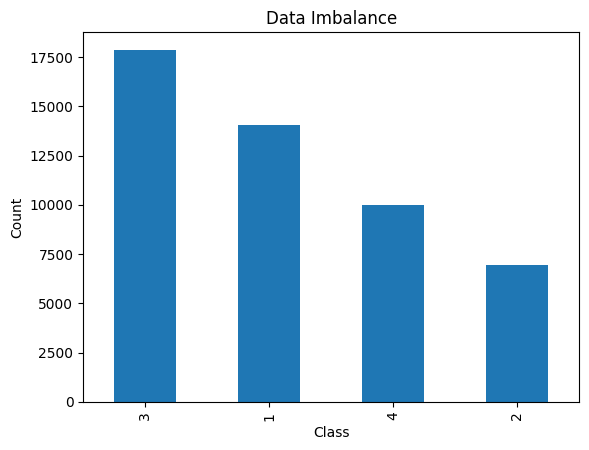

In [14]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in y_train
value_counts = y_train.value_counts()

# Plot the data imbalance in a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Imbalance')

# Display the bar chart
plt.show()

# Data Cleaning

In [3]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

# Preprocessors
def lowercase(text):
  return text.lower()

def lemmatize(text):
  words = word_tokenize(text)
  return ' '.join([lemmatizer.lemmatize(word) for word in words])

def stem(text):
  words = word_tokenize(text)
  return ' '.join([ps.stem(word) for word in words])

def remove_numbers(text):
  return re.sub(r'\d+', '', text)

def remove_punctuations(text):
  return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
  words = word_tokenize(text)
  return ' '.join([word for word in words if word not in stopwords.words('english')])

Preprocessor = {
    'LOWERCASE': lowercase,
    'LEMMATIZE': lemmatize,
    'STEM': stem,
    'REMOVE_NUMBERS': remove_numbers,
    'REMOVE_PUNCTUATIONS': remove_punctuations,
    'REMOVE_STOPWORDS': remove_stopwords
}

SAMPLE_TEXT = "I am going to bed, my school starts at 8:00."
BEFORE_AND_AFTER_PREPROCESS_LIST = [[preprocessor, SAMPLE_TEXT, Preprocessor[preprocessor](SAMPLE_TEXT)] for preprocessor in Preprocessor]
pd.DataFrame(BEFORE_AND_AFTER_PREPROCESS_LIST, columns=['Preprocessor', 'Before', 'After'])

,Preprocessor,Before,After
0,LOWERCASE,"I am going to bed, my school starts at 8:00.","i am going to bed, my school starts at 8:00."
1,LEMMATIZE,"I am going to bed, my school starts at 8:00.","I am going to bed , my school start at 8:00 ."
2,STEM,"I am going to bed, my school starts at 8:00.","i am go to bed , my school start at 8:00 ."
3,REMOVE_NUMBERS,"I am going to bed, my school starts at 8:00.","I am going to bed, my school starts at :."
4,REMOVE_PUNCTUATIONS,"I am going to bed, my school starts at 8:00.",I am going to bed my school starts at 800
5,REMOVE_STOPWORDS,"I am going to bed, my school starts at 8:00.","I going bed , school starts 8:00 ."


In [6]:
# Preprocess text
def combine_preprocessors(preprocessors):
  def preprocess(text):
    cleaned_text = text
    for preprocessor in preprocessors:
      cleaned_text = preprocessor(cleaned_text)

    return cleaned_text

  return preprocess

df['cleaned_text'] = df['Text'].apply(combine_preprocessors([
    Preprocessor['LOWERCASE'],
]))

df[['Text', 'cleaned_text']].head()

,Text,cleaned_text
0,"A little less than a decade ago, hockey fans w...","a little less than a decade ago, hockey fans w..."
1,The writers of the HBO series The Sopranos too...,the writers of the hbo series the sopranos too...
2,Despite claims from the TV news outlet to offe...,despite claims from the tv news outlet to offe...
3,After receiving 'subpar' service and experienc...,after receiving 'subpar' service and experienc...
4,After watching his beloved Seattle Mariners pr...,after watching his beloved seattle mariners pr...


Baseline Model (Count + Tfidf Vectorizer)

In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))  # Using a fixed random state for reproducibility
])

# Train the RandomForest model
pipeline.fit(X_train, y_train)

# Evaluate the model
predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.69      0.79      0.74       750
           2       0.63      0.26      0.37       750
           3       0.57      0.92      0.70       750
           4       0.88      0.71      0.78       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.65      3000
weighted avg       0.69      0.67      0.65      3000



In [20]:
pipeline = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))  # Using a fixed random state for reproducibility
])

# Train the RandomForest model
pipeline.fit(X_train, y_train)

# Evaluate the model
predictions = pipeline.predict(X_test)
prediction_train = pipeline.predict(X_train)
print(classification_report(y_test, predictions))
print(classification_report(y_train, prediction_train))

              precision    recall  f1-score   support

           1       0.64      0.79      0.71       750
           2       0.66      0.33      0.44       750
           3       0.57      0.87      0.69       750
           4       0.89      0.67      0.77       750

    accuracy                           0.66      3000
   macro avg       0.69      0.66      0.65      3000
weighted avg       0.69      0.66      0.65      3000



In [7]:
# Define the pipeline with TF-IDF vectorizer and XGBClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=10, random_state=42))  # Adjust XGBoost parameters as needed
])

# Define the parameter grid
param_grid = {
    'xgb__n_estimators': [200, 300, 400],
    'xgb__max_depth': [10, 12, 14],
    'xgb__learning_rate': [0.3, 0.5, 0.7]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=5)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Train the model on the training data
grid_search.fit(X_train, y_train_adjusted)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Evaluate the model on the test data
predictions = grid_search.predict(X_test)
print(classification_report(y_test_adjusted, predictions))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       750
           1       0.67      0.42      0.52       750
           2       0.58      0.71      0.64       750
           3       0.71      0.91      0.80       750

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.67      3000
weighted avg       0.69      0.68      0.67      3000

Best parameters:  {'xgb__learning_rate': 0.3, 'xgb__max_depth': 10, 'xgb__n_estimators': 400}


In [15]:
# Tokenize the text data
df['Tokenized_Text'] = df['Text'].apply(word_tokenize)
df_test['Tokenized_Text'] = df_test['Text'].apply(word_tokenize)

# Train a Word2Vec model (or load a pre-trained model)
model_w2v = Word2Vec(sentences=df['Tokenized_Text'], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model_w2v.wv

# Function to vectorize a text
def vectorize_text(text_tokens, model):
    vector = np.zeros(model.vector_size)
    num_words = 0
    for token in text_tokens:
        if token in model.key_to_index:
            vector += model[token]
            num_words += 1
    if num_words > 0:
        vector = vector / num_words
    return vector

# Vectorize the training and testing data
X_train = np.array([vectorize_text(tokens, word_vectors) for tokens in df['Tokenized_Text']])
X_test = np.array([vectorize_text(tokens, word_vectors) for tokens in df_test['Tokenized_Text']])
y_train = df['Verdict']
y_test = df_test['Verdict']

# Train a RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.67      0.61      0.64       750
           2       0.64      0.37      0.46       750
           3       0.53      0.83      0.65       750
           4       0.80      0.75      0.77       750

    accuracy                           0.64      3000
   macro avg       0.66      0.64      0.63      3000
weighted avg       0.66      0.64      0.63      3000



In [4]:
for preprocessor_name, preprocessor_func in Preprocessor.items():
    # Apply preprocessor
    df['Preprocessed_Text'] = df['Text'].apply(preprocessor_func)
    df_test['Preprocessed_Text'] = df_test['Text'].apply(preprocessor_func)
    
    # Prepare data
    X_train = df['Preprocessed_Text']
    y_train = df['Verdict']
    X_test = df_test['Preprocessed_Text']
    y_test = df_test['Verdict']
    
    # Pipeline
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))  # Using a fixed random state for reproducibility
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Evaluate
    predictions = pipeline.predict(X_test)
    
    # Results
    print(f"Results for {preprocessor_name}:")
    print(classification_report(y_test, predictions))

NameError: name 'Preprocessor' is not defined

Results for LOWERCASE:
              precision    recall  f1-score   support

           1       0.69      0.79      0.74       750
           2       0.63      0.26      0.37       750
           3       0.57      0.92      0.70       750
           4       0.88      0.71      0.78       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.65      3000
weighted avg       0.69      0.67      0.65      3000

Results for LEMMATIZE:
              precision    recall  f1-score   support

           1       0.70      0.81      0.75       750
           2       0.66      0.29      0.40       750
           3       0.57      0.92      0.70       750
           4       0.87      0.68      0.77       750

    accuracy                           0.68      3000
   macro avg       0.70      0.68      0.66      3000
weighted avg       0.70      0.68      0.66      3000

Results for STEM:
              precision    recall  f1-score   support

           1       0.68      0.81      0.73       750
           2       0.64      0.30      0.41       750
           3       0.56      0.92      0.69       750
           4       0.89      0.62      0.73       750

    accuracy                           0.66      3000
   macro avg       0.69      0.66      0.64      3000
weighted avg       0.69      0.66      0.64      3000

Results for REMOVE_NUMBERS:
              precision    recall  f1-score   support

           1       0.69      0.77      0.73       750
           2       0.65      0.29      0.40       750
           3       0.56      0.92      0.70       750
           4       0.88      0.70      0.78       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for REMOVE_PUNCTUATIONS:
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       750
           2       0.66      0.28      0.40       750
           3       0.56      0.91      0.69       750
           4       0.87      0.64      0.74       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.64      3000
weighted avg       0.69      0.67      0.64      3000

Results for REMOVE_STOPWORDS:
              precision    recall  f1-score   support

           1       0.70      0.78      0.74       750
           2       0.62      0.28      0.39       750
           3       0.57      0.92      0.70       750
           4       0.89      0.71      0.79       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.65      3000
weighted avg       0.69      0.67      0.65      3000

In [8]:
# Apply combined preprocessing steps
combined_preprocessor = combine_preprocessors([lowercase, lemmatize])
df['Preprocessed_Text'] = df['Text'].apply(combined_preprocessor)
df_test['Preprocessed_Text'] = df_test['Text'].apply(combined_preprocessor)

# Prepare data
X_train = df['Preprocessed_Text']
y_train = df['Verdict']
X_test = df_test['Preprocessed_Text']
y_test = df_test['Verdict']

# Define and train the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

# Evaluate the model
predictions = pipeline.predict(X_test)
print("Classification Report for Lowercase + Lemmatize:")
print(classification_report(y_test, predictions))

Classification Report for Lowercase + Lemmatize:
              precision    recall  f1-score   support

           1       0.71      0.79      0.75       750
           2       0.64      0.30      0.41       750
           3       0.56      0.93      0.70       750
           4       0.88      0.67      0.76       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000



# Feature Engineering

In [7]:
def count_words(text):
  words = text.split()
  return len(text.split())

def count_unique_words(text):
  words = text.split()
  unique_words = set(words)
  return len(unique_words) / count_words(text)

def count_adjectives(text):
  words = word_tokenize(text)
  tagged = nltk.pos_tag(words)
  return len([word for word, pos in tagged if pos in ['JJ', 'JJR', 'JJS']]) / count_words(text)
    
def count_nouns(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag in ['NN', 'NNS', 'NNP', 'NNPS']) / count_words(text)

def count_verbs(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag.startswith('VB')) / count_words(text)

def count_adverbs(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag in ['RB', 'RBR', 'RBS']) / count_words(text)

def count_pronouns(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag in ['PRP', 'PRP$', 'WP', 'WP$']) / count_words(text)

def count_modals(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag == 'MD') / count_words(text)

def count_conjunctions(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag == 'CC') / count_words(text)

def count_prepositions(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag == 'IN') / count_words(text)

def count_interjections(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag == 'UH') / count_words(text)

def count_determiners(text):
    tags = pos_tag(word_tokenize(text))
    return sum(1 for word, tag in tags if tag in ['DT', 'PDT']) / count_words(text)

def count_contractions(text):
    count = 0
    count += re.subn(r"won't", '', text)[1]
    count += re.subn(r"can't", '', text)[1]
    count += re.subn(r"n't", '', text)[1]
    count += re.subn(r"'re", '', text)[1]
    count += re.subn(r"'s", '', text)[1]
    count += re.subn(r"'d", '', text)[1]
    count += re.subn(r"'ll", '', text)[1]
    count += re.subn(r"'t", '', text)[1]
    count += re.subn(r"'ve", '', text)[1]
    count += re.subn(r"'m", '', text)[1]
    return count / count_words(text)

def count_named_entities(text):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    # Tokenize sentences into words and tag part of speech
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    pos_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    # Chunk sentences to identify named entities
    chunked_sentences = [ne_chunk(sentence) for sentence in pos_sentences]
    # Count the named entities
    named_entities_count = sum(1 for sentence in chunked_sentences for chunk in sentence if isinstance(chunk, Tree))
    return named_entities_count / count_words(text)

def dialogue_percentage(text):
    dialogues = re.findall(r'["\']([^"\']*)["\']', text)
    dialogue_chars = sum(len(dialogue) for dialogue in dialogues)
    total_chars = len(text)
    
    if total_chars > 0:
        return (dialogue_chars / total_chars) 
    else:
        return 0

def text_subjectivity(text):
    return TextBlob(text).subjectivity

def text_polarity(text):
    return TextBlob(text).polarity

FeatureExtractor = {
    'COUNT_WORDS': count_words,
    'COUNT_UNIQUE_WORDS': count_unique_words,
    'COUNT_ADJECTIVES': count_adjectives,
    'COUNT_NOUNS': count_nouns,
    'COUNT_VERBS': count_verbs,
    'COUNT_ADVERBS': count_adverbs,
    'COUNT_PRONOUNS': count_pronouns,
    'COUNT_MODALS': count_modals,
    'COUNT_CONJUNCTIONS': count_conjunctions,
    'COUNT_PREPOSITIONS': count_prepositions,
    'COUNT_INTERJECTIONS': count_interjections,
    'COUNT_DETERMINERS': count_determiners,
    'COUNT_CONTRACTIONS': count_contractions,
    'COUNT_NAMED_ENTITIES': count_named_entities,
    'DIALOGUE_PERCENTAGE': dialogue_percentage,
    'TEXT_SUBJECTIVITY': text_subjectivity,
    'TEXT_POLARITY': text_polarity
}

SAMPLE_TEXT = "I am going to bed, my beautiful day starts at 8:00. 'hi my name is yong jie' "
FEATURE_EXTRACTION_OUTPUT_LIST = [[feature_extractor, SAMPLE_TEXT, FeatureExtractor[feature_extractor](SAMPLE_TEXT)] for feature_extractor in FeatureExtractor]
pd.DataFrame(FEATURE_EXTRACTION_OUTPUT_LIST, columns=['Feature Extractor', 'Input', 'Output'])

,Feature Extractor,Input,Output
0,COUNT_WORDS,"I am going to bed, my beautiful day starts at ...",17.000000
1,COUNT_UNIQUE_WORDS,"I am going to bed, my beautiful day starts at ...",0.941176
2,COUNT_ADJECTIVES,"I am going to bed, my beautiful day starts at ...",0.117647
3,COUNT_NOUNS,"I am going to bed, my beautiful day starts at ...",0.235294
4,COUNT_VERBS,"I am going to bed, my beautiful day starts at ...",0.294118
5,COUNT_ADVERBS,"I am going to bed, my beautiful day starts at ...",0.000000
6,COUNT_PRONOUNS,"I am going to bed, my beautiful day starts at ...",0.176471
7,COUNT_MODALS,"I am going to bed, my beautiful day starts at ...",0.000000
8,COUNT_CONJUNCTIONS,"I am going to bed, my beautiful day starts at ...",0.000000
9,COUNT_PREPOSITIONS,"I am going to bed, my beautiful day starts at ...",0.058824


In [30]:
# Extract primary features
feature_column_to_feature_extractor = {
    'word_count': FeatureExtractor['COUNT_WORDS'],
    'unique_word_count': FeatureExtractor['COUNT_UNIQUE_WORDS'],
    'adjective_count': FeatureExtractor['COUNT_ADJECTIVES'],
    'noun_count': FeatureExtractor['COUNT_NOUNS'],
    'verb_count': FeatureExtractor['COUNT_VERBS'],
    'adverb_count': FeatureExtractor['COUNT_ADVERBS'],
    'pronoun_count': FeatureExtractor['COUNT_PRONOUNS'],
    'modal_count': FeatureExtractor['COUNT_MODALS'],
    'conjunction_count': FeatureExtractor['COUNT_CONJUNCTIONS'],
    'preposition_count': FeatureExtractor['COUNT_PREPOSITIONS'],
    'interjection_count': FeatureExtractor['COUNT_INTERJECTIONS'],
    'determiner_count': FeatureExtractor['COUNT_DETERMINERS'],
    'contraction_count': FeatureExtractor['COUNT_CONTRACTIONS'],
    'named_entity_count': FeatureExtractor['COUNT_NAMED_ENTITIES'],
    'dialogue_percentage': FeatureExtractor['DIALOGUE_PERCENTAGE'],
    'text_subjectivity': FeatureExtractor['TEXT_SUBJECTIVITY'],
    'text_polarity': FeatureExtractor['TEXT_POLARITY']
}

PRIMARY_FEATURE_COLUMNS = {key.upper(): key for key in feature_column_to_feature_extractor.keys()}

for feature_col in feature_column_to_feature_extractor:
  print(feature_col)
  df[feature_col] = df['Text'].apply(feature_column_to_feature_extractor[feature_col])

df[['Text'] + list(PRIMARY_FEATURE_COLUMNS.values())].head()

word_count
unique_word_count
adjective_count


KeyboardInterrupt: 

In [ ]:
# Calculate secondary features
df['unique_word_count_vs_word_count'] = df[PRIMARY_FEATURE_COLUMNS['UNIQUE_WORD_COUNT']] / df[PRIMARY_FEATURE_COLUMNS['WORD_COUNT']]

SECONDARY_FEATURE_COLUMNS = {
    'UNIQUE_WORD_COUNT_VS_WORD_COUNT': 'unique_word_count_vs_word_count'
}

df[['Text'] + list(SECONDARY_FEATURE_COLUMNS.values())].head()

,Text,unique_word_count_vs_word_count
0,"A little less than a decade ago, hockey fans w...",1.000000
1,The writers of the HBO series The Sopranos too...,0.991803
2,Despite claims from the TV news outlet to offe...,0.970213
3,After receiving 'subpar' service and experienc...,0.990071
4,After watching his beloved Seattle Mariners pr...,1.000000


In [3]:
X_train = X_train.apply(lemmatize)
X_test = X_test.apply(lemmatize)

NameError: name 'lemmatize' is not defined

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Function to apply a feature extractor and return the feature as a DataFrame
def extract_feature_series(X, feature_func):
    return X.apply(feature_func).to_frame()

In [7]:
results = {}

for feature_name, feature_func in FeatureExtractor.items():
    # Apply the feature extractor function to training and test sets
    train_feature = extract_feature_series(X_train, feature_func)
    test_feature = extract_feature_series(X_test, feature_func)
    
    # Combine the TF-IDF features with the extracted feature
    X_train_combined = np.hstack((X_train_tfidf.toarray(), train_feature))
    X_test_combined = np.hstack((X_test_tfidf.toarray(), test_feature))
    
    # Train the RandomForest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_combined, y_train)
    
    # Make predictions and evaluate the model
    predictions = rf_model.predict(X_test_combined)
    report = classification_report(y_test, predictions, output_dict=True)
    
    # Store the report for later analysis
    results[feature_name] = report['accuracy']  # You can store other metrics of interest
    
    # Print out the classification report for this feature
    print(f"Results for {feature_name}:")
    print(classification_report(y_test, predictions))

Results for DIALOGUE_PERCENTAGE:
              precision    recall  f1-score   support

           1       0.65      0.77      0.71       750
           2       0.62      0.30      0.41       750
           3       0.55      0.86      0.67       750
           4       0.88      0.69      0.77       750

    accuracy                           0.66      3000
   macro avg       0.68      0.66      0.64      3000
weighted avg       0.68      0.66      0.64      3000

Results for TEXT_SUBJECTIVITY:
              precision    recall  f1-score   support

           1       0.69      0.83      0.75       750
           2       0.67      0.31      0.42       750
           3       0.57      0.92      0.71       750
           4       0.88      0.67      0.76       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.66      3000
weighted avg       0.71      0.68      0.66      3000

Results for TEXT_POLARITY:
              precision    recall  f1-s

Results for COUNT_WORDS:
              precision    recall  f1-score   support

           1       0.69      0.81      0.74       750
           2       0.64      0.29      0.40       750
           3       0.57      0.91      0.70       750
           4       0.89      0.67      0.77       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_UNIQUE_WORDS:
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       750
           2       0.67      0.30      0.41       750
           3       0.57      0.90      0.70       750
           4       0.86      0.67      0.76       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_ADJECTIVES:
              precision    recall  f1-score   support

           1       0.68      0.83      0.75       750
           2       0.67      0.30      0.41       750
           3       0.58      0.92      0.71       750
           4       0.90      0.66      0.76       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.66      3000
weighted avg       0.71      0.68      0.66      3000

Results for COUNT_NOUNS:
              precision    recall  f1-score   support

           1       0.69      0.83      0.75       750
           2       0.67      0.31      0.42       750
           3       0.56      0.90      0.69       750
           4       0.87      0.66      0.75       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_VERBS:
              precision    recall  f1-score   support

           1       0.69      0.81      0.75       750
           2       0.66      0.30      0.41       750
           3       0.56      0.91      0.69       750
           4       0.88      0.66      0.75       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_ADVERBS:
              precision    recall  f1-score   support

           1       0.68      0.82      0.74       750
           2       0.65      0.29      0.40       750
           3       0.56      0.91      0.70       750
           4       0.90      0.66      0.76       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_PRONOUNS:
              precision    recall  f1-score   support

           1       0.68      0.82      0.74       750
           2       0.66      0.29      0.40       750
           3       0.57      0.91      0.70       750
           4       0.89      0.67      0.76       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_MODALS:
              precision    recall  f1-score   support

           1       0.70      0.85      0.76       750
           2       0.68      0.29      0.40       750
           3       0.56      0.90      0.69       750
           4       0.88      0.67      0.76       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.66      3000
weighted avg       0.71      0.68      0.66      3000

Results for COUNT_CONJUNCTIONS:
              precision    recall  f1-score   support

           1       0.69      0.81      0.75       750
           2       0.66      0.30      0.42       750
           3       0.57      0.91      0.70       750
           4       0.89      0.67      0.77       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.66      3000
weighted avg       0.70      0.67      0.66      3000

Results for COUNT_PREPOSITIONS:
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       750
           2       0.66      0.29      0.40       750
           3       0.57      0.92      0.70       750
           4       0.89      0.66      0.76       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_INTERJECTIONS:
              precision    recall  f1-score   support

           1       0.69      0.83      0.75       750
           2       0.67      0.29      0.41       750
           3       0.57      0.92      0.70       750
           4       0.88      0.66      0.75       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_DETERMINERS:
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       750
           2       0.66      0.30      0.41       750
           3       0.57      0.91      0.70       750
           4       0.87      0.66      0.75       750

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.65      3000
weighted avg       0.70      0.67      0.65      3000

Results for COUNT_NAMED_ENTITIES:
              precision    recall  f1-score   support

           1       0.68      0.78      0.73       750
           2       0.64      0.30      0.41       750
           3       0.56      0.90      0.69       750
           4       0.89      0.70      0.78       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.65      3000
weighted avg       0.69      0.67      0.65      3000

Results for DIALOGUE_PERCENTAGE:
              precision    recall  f1-score   support

           1       0.65      0.77      0.71       750
           2       0.62      0.30      0.41       750
           3       0.55      0.86      0.67       750
           4       0.88      0.69      0.77       750

    accuracy                           0.66      3000
   macro avg       0.68      0.66      0.64      3000
weighted avg       0.68      0.66      0.64      3000

Results for TEXT_SUBJECTIVITY:
              precision    recall  f1-score   support

           1       0.69      0.83      0.75       750
           2       0.67      0.31      0.42       750
           3       0.57      0.92      0.71       750
           4       0.88      0.67      0.76       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.66      3000
weighted avg       0.71      0.68      0.66      3000

Results for TEXT_POLARITY:
              precision    recall  f1-score   support

           1       0.68      0.81      0.74       750
           2       0.63      0.28      0.39       750
           3       0.55      0.91      0.69       750
           4       0.89      0.65      0.75       750

    accuracy                           0.66      3000
   macro avg       0.69      0.66      0.64      3000
weighted avg       0.69      0.66      0.64      3000


In [11]:
# Select only the desired feature extractors
selected_features = {
    'count_adjectives': FeatureExtractor['COUNT_ADJECTIVES'],
    'count_modals': FeatureExtractor['COUNT_MODALS'],
    'text_subjectivity': FeatureExtractor['TEXT_SUBJECTIVITY']
}

# Initialize containers for the selected feature data
train_features_selected = []
test_features_selected = []

# Extract the selected features and store them in lists
for feature_name, feature_func in selected_features.items():
    train_feature = extract_feature_series(X_train, feature_func)
    test_feature = extract_feature_series(X_test, feature_func)
    train_features_selected.append(train_feature)
    test_features_selected.append(test_feature)

# Combine the selected features for training and testing sets
# Use hstack to ensure compatibility with sparse matrices from TF-IDF
X_train_combined_selected = hstack([X_train_tfidf] + train_features_selected)
X_test_combined_selected = hstack([X_test_tfidf] + test_features_selected)

# Train the RandomForest model with the combined selected features
rf_model_selected = RandomForestClassifier(random_state=42)
rf_model_selected.fit(X_train_combined_selected, y_train)

# Make predictions and evaluate the model
predictions_selected = rf_model_selected.predict(X_test_combined_selected)
report_selected = classification_report(y_test, predictions_selected, output_dict=True)

# Print out the classification report for the combined features
print("Results for combined features (count_adjectives, count_modals, text_subjectivity):")
print(classification_report(y_test, predictions_selected))

Results for combined features (count_adjectives, count_modals, text_subjectivity):
              precision    recall  f1-score   support

           1       0.69      0.82      0.75       750
           2       0.66      0.31      0.42       750
           3       0.57      0.91      0.70       750
           4       0.89      0.67      0.76       750

    accuracy                           0.68      3000
   macro avg       0.70      0.68      0.66      3000
weighted avg       0.70      0.68      0.66      3000



# Text Vectorization

In [ ]:
# Vectorizers
# doc-to-vec


A little less than a decade ago, hockey fans were blessed with a slate of games every night, but on Thursday sources confirmed that for the ninth consecutive year NHL players have been locked out, with very slim hopes of an agreement in sight. It seems like just yesterday Martin St. Louis and his Lightning teammates were raising the Stanley Cup, high school hockey coach and onetime ESPN analyst Barry Melrose said. Obviously, Im still hoping the two sides can come together and reach an agreement, but Im starting to think nobody really misses hockey anymore. Nope. Nobody but old Barry. Id still love to catch an Atlanta Thrashers game. Observers have noted that when arena doors do reopen, the NHL will face the perhaps greater challenge of convincing fans to return to hockey instead of watching more popular sports like football, basketball, baseball, and SlamBall. 


# Model Selection

In [ ]:
model = ...
model.fit(X_train, y_train)

# Model Scoring

In [ ]:
f1score